# Refitting PyMC3 models with ArviZ

ArviZ is backend agnostic and therefore does not sample directly. In order to take advantage of algorithms that require refitting models several times, ArviZ uses `SamplingWrappers` to convert the API of the sampling backend to a common set of functions. Hence, functions like Leave Future Out Cross Validation can be used in ArviZ independently of the sampling backend used.

Below there is one example of `SamplingWrapper` usage for PyMC3.

Before starting, it is important to note that PyMC3 cannot modify the shapes of the input data using the same compiled model. Thus, each refitting will require a recompilation of the model.

In [1]:
import arviz as az
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

For the example we will use a linear regression.

In [2]:
np.random.seed(26)

xdata = np.linspace(0, 50, 100)
b0, b1, sigma = -2, 1, 3
ydata = np.random.normal(loc=b1 * xdata + b0, scale=sigma)

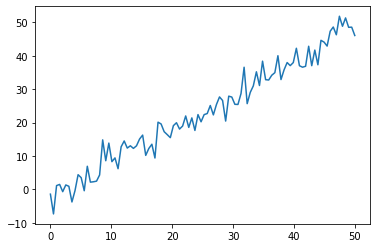

In [3]:
plt.plot(xdata, ydata);

Now we will write the PyMC3 model, keeping in mind that 1) data must be modifiable (both `x` and `y`) and 2) the model must be recompiled in order to be refitted with the modified data. We therefore have to create a function that recompiles the model when it's called.

Note how we would generally use `pm.Data` to populate `xyz_data` groups in the InferenceData result, however, given that we need to recompile the model every time, we are consciously skipping this step to speed up the recompilation. 

In [4]:
def compile_linreg_model(xdata, ydata):
    with pm.Model() as model:
        b0 = pm.Normal("b0", 0, 10)
        b1 = pm.Normal("b1", 0, 10)
        sigma_e = pm.HalfNormal("sigma_e", 10)

        y = pm.Normal("y", b0 + b1 * xdata, sigma_e, observed=ydata)
    return model

In [5]:
sample_kwargs = {"draws": 500, "tune": 500, "chains": 4}
with compile_linreg_model(xdata, ydata) as linreg_model:
    trace = pm.sample(**sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_e, b1, b0]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.917825834816141, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8850799498280131, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8818306765045102, but should be close to 0.8. Try to increase the number of tuning steps.


We have defined a dictionary `sample_kwargs` that will be passed to the `SamplingWrapper` in order to make sure that all refits use the same sampler parameters. 

We follow the same pattern with `az.from_pymc3`. 

Note however, how `coords` are not set. This is done to prevent errors due to coordinates and values shapes being incompatible during refits. Otherwise we'd have to handle subsetting of the coordinate values even though the refits are never used outside the refitting functions such as `reloo`.

We also exclude the `model` because the `model`, like the `trace`, is different for every refit. This may seem counterintuitive or even plain wrong, but we have to remember that the `pm.Model` object contains information like the observed data.

In [6]:
dims = {"y": ["time"]}
idata_kwargs = {
    "dims": dims,
}
idata = az.from_pymc3(trace, model=linreg_model, **idata_kwargs)

We will create a subclass of `az.SamplingWrapper`. 

In [7]:
class PyMC3LinRegWrapper(az.SamplingWrapper):
    def __init__(self, xdata, ydata, **kwargs):
        super(PyMC3LinRegWrapper, self).__init__(**kwargs)

        self.xdata = xdata
        self.ydata = ydata
        
    def sample(self, modified_observed_data):
        with self.model(**modified_observed_data) as linreg_model:
            trace = pm.sample(
                **self.sample_kwargs, 
                return_inferencedata=False, 
                idata_kwargs={"log_likelihood": False}
            )
        self.pymc3_model = linreg_model
        return trace
    
    def get_inference_data(self, trace):
        idata = az.from_pymc3(trace, model=self.pymc3_model, **self.idata_kwargs)
        idata.pymc3_trace = trace
        return idata
        
    def log_likelihood__i(self, excluded_observed_data, idata__i):
        model_ex = compile_linreg_model(**excluded_observed_data)
        log_lik__i = az.from_pymc3(idata__i.pymc3_trace, model=model_ex).log_likelihood["y"]
        return log_lik__i
        
    def sel_observations(self, idx):
        mask = np.isin(np.arange(len(self.xdata)), idx)
        data_dict = {"xdata": self.xdata, "ydata": self.ydata}
        data__i = {key: value[~mask] for key, value in data_dict.items()}
        data_ex = {key: value[mask] for key, value in data_dict.items()}
        return data__i, data_ex

In [8]:
loo_orig = az.loo(idata, pointwise=True)
loo_orig

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.78     7.13
p_loo        2.96        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In this case, the Leave-One-Out Cross Validation (LOO-CV) approximation using Pareto Smoothed Importance Sampling (PSIS) works for all observations, so we will use modify `loo_orig` in order to make `az.reloo` believe that PSIS failed for some observations. This will also serve as a validation of our wrapper, as the PSIS LOO-CV already returned the correct value.

In [9]:
loo_orig.pareto_k[[13, 42, 56, 73]] = np.array([0.8, 1.2, 2.6, 0.9])

We initialize our sampling wrapper

In [10]:
pymc3_wrapper = PyMC3LinRegWrapper(
    model=compile_linreg_model, xdata=xdata, ydata=ydata, sample_kwargs=sample_kwargs, idata_kwargs=idata_kwargs
)

And eventually, we can use this wrapper to call `az.reloo`, and compare the results with the PSIS LOO-CV results.

In [11]:
loo_relooed = az.reloo(pymc3_wrapper, loo_orig=loo_orig)

/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 13
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_e, b1, b0]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.9084390959319811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833232031335186, but should be close to 0.8. Try to increase the number of tuning steps.
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 42
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_e, b1, b0]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8788024509211416, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.900598064671754, but should be close to 0.8. Try to increase the number of tuning steps.
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 56
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_e, b1, b0]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8949149672236311, but should be close to 0.8. Try to increase the number of tuning steps.
arviz.stats.stats_refitting - INFO - Refitting model excluding observation 73
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_e, b1, b0]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8797995668769552, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882380854441132, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8936869082173754, but should be close to 0.8. Try to increase the number of tuning steps.


In [12]:
loo_relooed

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.77     7.13
p_loo        2.95        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [13]:
loo_orig

Computed from 2000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.78     7.13
p_loo        2.96        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       96   96.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)    2    2.0%